/tmp/ipykernel_3526/4273015143.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


linear_score = 0.7691752923789887
lasso_score = 0.7698817669529552 alpha = 0.9636627605010293
ridge_score = 0.7699518420079109 alpha = 0.9636627605010293


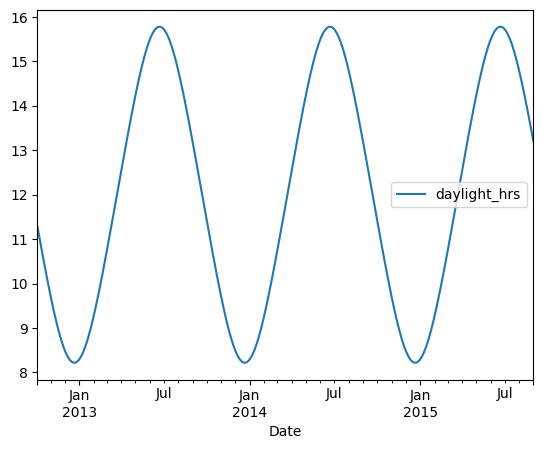

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import pandas as pd

# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

# these two files are large, and it may take a while to read...
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0

daily['holiday'].fillna(0, inplace=True)

# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 

daily['annual'] = (daily.index - daily.index[0]).days / 365.
daily.head()

daily.dropna(axis=0, how='any', inplace=True)

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

distributions = dict(alpha=uniform())

model = LinearRegression(fit_intercept=False)
model_score = cross_val_score(model, X, y, cv=10).mean()

lrscv = RandomizedSearchCV(Lasso(), distributions, random_state=0)
lrscv.fit(X, y)
lasso_model = Lasso(alpha=lrscv.best_params_['alpha'])
lasso_score = cross_val_score(lasso_model, X, y, cv=10).mean()

rrscv = RandomizedSearchCV(Ridge(), distributions, random_state=0)
rrscv.fit(X, y)
ridge_model = Ridge(alpha=rrscv.best_params_['alpha'])
ridge_score = cross_val_score(ridge_model, X, y, cv=10).mean()

print('linear_score = ' + repr(model_score))
print('lasso_score = ' + repr(lasso_score) + ' alpha = ' + repr(lasso_model.get_params()['alpha']))
print('ridge_score = ' + repr(ridge_score) + ' alpha = ' + repr(ridge_model.get_params()['alpha']))